## Preparation of data

### Labeling Data and converting images to array values

In [1]:
#import packages for labelling and converting imagery data
import pandas as pd
import numpy as np
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import asarray

In [2]:
##############
# Func for creating 1D image arrays

def load_image_function(path):
    images = [] # empty list placeholder
    labels = [] # empty list placeholder
    container = [] # container to validate correct labels
    for filename in os.listdir(path):
        container.append(filename) # add filename to container     
        CCDY_img = load_img(path + f'/{filename}', target_size = (56, 106),
        color_mode="grayscale")                  
        CCDY_img = img_to_array(CCDY_img)
        images.append(CCDY_img) # append the photo to the images. The images list contains a list of arrays       
    return asarray(images), container; # not interested in list of arrays, but array containing lists. Asarray does this. Returns three arrays


In [4]:
################
# Func for creating df with classes and 3d img arrays

def load_img_data ():
    # Start: creatign classes ons string_digits
    # load string digits

    #os.chdir(path_string_digits)

    string_digits = pd.read_csv('DIDA_12000_String_Digit_Labels.csv', 
                 header = None, 
                 names=["index", "string"])
    # create empty class columns
    string_digits['CC'] = 0
    string_digits['D'] = 0
    string_digits['Y'] = 0
    string_digits = string_digits.astype(str)
    # Iterate string digits and append classes
    for i, row in string_digits.iterrows():
        if len(row['string']) != 4:
            row['CC'] = '1'
            row['D'] = '10'
            row['Y'] = '10'
        else:
            row['D'] = row['string'][2]
            row['Y'] = row['string'][3]
            if row['string'][0:2] == '18':
                row['CC']='0'
            else:
                row['CC']='1'
    # End of class labeling on string_digits.
    #
    # Start: create img_df containing scaled images as 1D tensors
    # Convert imagery to 1D arrays with tagged file names

    #os.chdir(path_images)
    image_array, filename = load_image_function('DIDA_12000_String_Digit_Images/DIDA_1')

    # and convert to a img_df
    img_df = pd.DataFrame({'filename': filename, 'img_value': list(image_array)}, 
                          columns=['filename', 'img_value'])
    # Create proper index value in img_df to allow merge on string_digits
    img_df['index'] = img_df['filename']
    for i, row in img_df.iterrows():
        row['index'] = str(img_df['index'][i]).split('.')[0]
    img_df
    # End of creating img_df
    #
    # Start: merge img_df with string_digits
    # match index type on dataframes to merge
    string_digits['index'] = string_digits['index'].astype(int)
    img_df['index'] = img_df['index'].astype(int)
    # Merge dataframes
    df_img_classes = string_digits.merge(img_df)
    # Rearrange order of dataframe
    df_img_classes = df_img_classes.reindex(columns= ['index', 'string', 'CC', 'D', 'Y', 'img_value', 'filename'])
    # End og merging data frames
    return df_img_classes


In [5]:
#load data and shuffle them around
df = load_img_data()
df = df.sample(frac=1).reset_index(drop=True)
df

,index,string,CC,D,Y,img_value,filename
0,10082,1832,0,3,2,"[[[180.0], [175.0], [183.0], [179.0], [182.0],...",10082.jpg
1,6743,1826,0,2,6,"[[[136.0], [137.0], [138.0], [139.0], [135.0],...",6743.jpg
2,8678,1814,0,1,4,"[[[85.0], [91.0], [93.0], [88.0], [89.0], [89....",8678.jpg
3,2230,1815,0,1,5,"[[[176.0], [176.0], [173.0], [172.0], [172.0],...",2230.jpg
4,11471,1821,0,2,1,"[[[159.0], [158.0], [153.0], [154.0], [158.0],...",11471.jpg
...,...,...,...,...,...,...,...
11995,9377,1831,0,3,1,"[[[181.0], [181.0], [181.0], [180.0], [179.0],...",9377.jpg
11996,8267,1835,0,3,5,"[[[133.0], [133.0], [136.0], [129.0], [141.0],...",8267.jpg
11997,6943,1833,0,3,3,"[[[130.0], [131.0], [132.0], [132.0], [131.0],...",6943.jpg
11998,10708,1800,0,0,0,"[[[181.0], [179.0], [179.0], [181.0], [181.0],...",10708.jpg


### Defining fixed train, test and valdiation sets.

In [6]:
df = df.drop(columns=['index','string','filename'])

### Split train, val, test

#### Subsetting df

In [7]:
x_train = df.loc[0:7679]
x_val = df.loc[7680:9599]
x_test = df.loc[9600:11999]

#### Creating labels

In [8]:
#### training labels ###
Y_train = x_train['Y']
Y_train = Y_train.astype(np.uint8)
D_train = x_train['D']
D_train = D_train.astype(np.uint8)
CC_train = x_train['CC']
CC_train = CC_train.astype(np.uint8)

#### validation labels ###
Y_val = x_val['Y']
Y_val = Y_val.astype(np.uint8)
D_val = x_val['D']
D_val = D_val.astype(np.uint8)
CC_val = x_val['CC']
CC_val = CC_val.astype(np.uint8)

#### test labels ###
Y_test = x_test['Y']
Y_test = Y_test.astype(np.uint8)
D_test = x_test['D']
D_test = D_test.astype(np.uint8)
CC_test = x_test['CC']
CC_test = CC_test.astype(np.uint8)


#### Creating image values

In [9]:
# train
values = np.zeros(shape=(len(x_train),56,106,1))
i = 0
j = 0
while i < len(x_train):
    values[i] = x_train['img_value'][j]
    i += 1
    j+=1
x_train = values/255

# val
values = np.zeros(shape=(len(x_val),56,106,1))
i = 0
j = 7680
while i < len(x_val):
    values[i] = x_val['img_value'][j]
    i += 1
    j+=1
x_val = values/255

# test
values = np.zeros(shape=(len(x_test),56,106,1))
i = 0
j = 9600
while i < len(x_test):
    values[i] = x_test['img_value'][j]
    i += 1
    j+=1
x_test = values/255


## Question 2.3, Testing the final models

### Initializing CNN's

In [10]:
import tensorflow as tf
import data_loader as dl
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.03, input_shape=(56, 106, 1))
    ])


#### Model CC

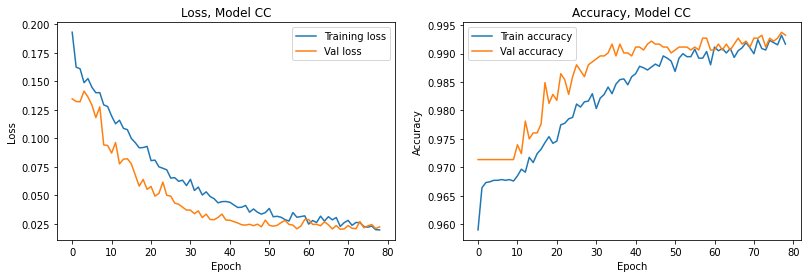

In [12]:
### With Augmentation
model_CC_aug = tf.keras.models.Sequential([
    data_augmentation,
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

model_CC_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'binary_crossentropy',
    metrics=['accuracy'],
    ) 

history_CC_aug = model_CC_aug.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

############################

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_CC_aug.history['loss'], label='Training loss')
ax.plot(history_CC_aug.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model CC')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_CC_aug.history['accuracy'], label='Train accuracy')
ax.plot(history_CC_aug.history['val_accuracy'], label = 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model CC')

plt.show()


Valdiation accuracy, before in report 0.9895

In [13]:
history_CC_aug.history['val_accuracy'][-1]

0.9932291507720947

Validation loss, before in report 0.0465

In [14]:
history_CC_aug.history['val_loss'][-1]

0.022422373294830322

#### Model D

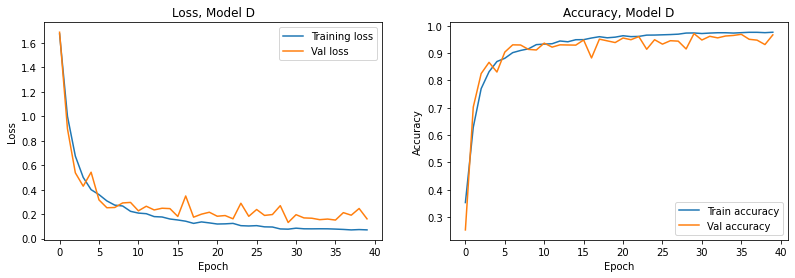

In [15]:
### With Augmentation
model_D_aug = tf.keras.models.Sequential([
    data_augmentation,
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_D_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_D_aug = model_D_aug.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

############################

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_D_aug.history['loss'], label='Training loss')
ax.plot(history_D_aug.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model D')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_D_aug.history['accuracy'], label='Train accuracy')
ax.plot(history_D_aug.history['val_accuracy'], label = 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model D')

plt.show()


Valdiation accuracy, before in report 0.9494

In [16]:
history_D_aug.history['val_accuracy'][-1]

0.9666666388511658

Validation loss, before in report 0.1805

In [17]:
history_D_aug.history['val_loss'][-1]

0.16185861825942993

#### Model Y

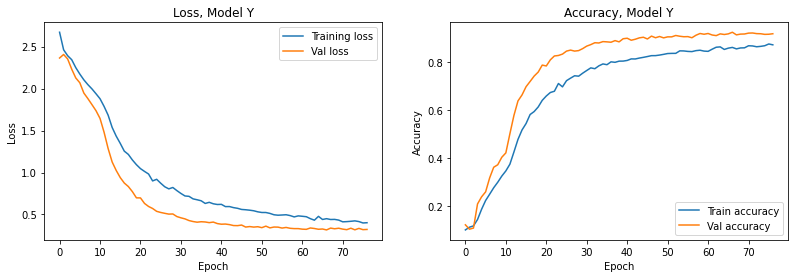

In [18]:
### With Augmentation
model_Y_aug = tf.keras.models.Sequential([
    data_augmentation,
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_Y_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_Y_aug = model_Y_aug.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

############################

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_Y_aug.history['loss'], label='Training loss')
ax.plot(history_Y_aug.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model Y')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_Y_aug.history['accuracy'], label='Train accuracy')
ax.plot(history_Y_aug.history['val_accuracy'], label = 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model Y')

plt.show()


Validation accuracy, before in report 0.9171

In [19]:
history_Y_aug.history['val_accuracy'][-1]

0.9192708134651184

Validation loss, before in report 0.3898

In [20]:
history_Y_aug.history['val_loss'][-1]

0.3214839994907379

### Measurign test set accuracy

In [23]:
CC_test_acc = model_CC_aug.evaluate(x_test,CC_test)
D_test_acc = model_D_aug.evaluate(x_test,D_test)
Y_test_acc = model_Y_aug.evaluate(x_test,Y_test)
print(CC_test_acc)
print(D_test_acc)
print(Y_test_acc)

75/75 [==============================] - 0s 5ms/step - loss: 0.3498 - accuracy: 0.9204: 0s - loss: 0.3130 - accuracy: 
[0.038886893540620804, 0.9925000071525574]
[0.1640990823507309, 0.9708333611488342]
[0.3497786521911621, 0.9204166531562805]


In [65]:
def accuracy_calc(model,y_test,x_test):
    preds = model.predict(x_test)
    classes = np.argmax(preds, axis = 1)
    score = 0.0
    i = 0
    for row in y_test:
        if row == classes[i]:
            score = score + (1/3)
        i= i + 1
    return score

In [66]:
test_score_CC = accuracy_calc(model_CC_aug,CC_test,x_test)
test_score_D = accuracy_calc(model_D_aug,D_test,x_test)
test_score_Y = accuracy_calc(model_Y_aug,Y_test,x_test)
print(test_score_CC)
print(test_score_D)
print(test_score_Y)
score = ((test_score_Y+test_score_CC+test_score_D)/len(Y_test))*100
score

771.3333333333511
776.666666666685
736.3333333333471


95.18055555555765

In [72]:
array = np.array(CC_test)
print(array)

[0 0 0 ... 0 0 0]


In [73]:
def sequence_calc(model_CC,model_D,model_Y,CC_test,D_test,Y_test,x_test):
    preds_CC = model_CC.predict(x_test)
    preds_D = model_D.predict(x_test)
    preds_Y = model_Y.predict(x_test)
    classes_CC = np.argmax(preds_CC, axis = 1)
    classes_D = np.argmax(preds_D, axis = 1)
    classes_Y = np.argmax(preds_Y, axis = 1)
    CC_array = np.array(CC_test)
    D_array = np.array(D_test)
    Y_array = np.array(Y_test)
    score = 0.0
    i = 0
    while i < len(CC_test):
        if CC_array[i] == classes_CC[i]:
            if D_array[i] == classes_D[i]:
                if Y_array[i] == classes_Y[i]:
                    score = score + 1
        i= i + 1
    return score


In [75]:
seq_acc = (sequence_calc(model_CC_aug,model_D_aug,model_Y_aug,CC_test,D_test,Y_test,x_test)/len(CC_test))*100
seq_acc

87.54166666666666